In [176]:
# Load the autoreload extension
%load_ext autoreload

# Autoreload reloads modules before executing code
# 0: disable
# 1: reload modules imported with %aimport
# 2: reload all modules, except those excluded by %aimport
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [177]:
import numpy as np 
import matplotlib.pyplot as plt 
import sys
sys.path.insert(1, "../src/")
from _generate_time_series import *
from _clustering import *
import _tracking as tk

In [178]:
# stiffness and mass: 
kx=np.array([10,2])*4000
ky=np.array([7,1.8])*4000
m=np.array([1,1])*500

#number of time series to run
n_runs=150

#shapes for how the stiffnesses should behave trougout the time series:
shapex=np.vstack((np.ones((1,n_runs)), np.sin(np.arange(0,n_runs)/np.pi)))+2
shapey=np.vstack((np.ones((1,n_runs)), np.ones((1,n_runs))))+1.5

shapey[0, n_runs//3:] += np.linspace(0,2,2*n_runs//3)
shapey[1, n_runs//2:] += 2

#shapex = np.ones(n_runs)
#shapey = np.ones(n_runs)

#What modal orders to run in the cov-ssi:
orders=np.arange(2,50,1)

#sampling frequency and lengt of each time series:
fs=7        #Hz
T_max=3000  #sec
t=np.arange(0,T_max,1/fs)

# specify parameters for the load series: 
    # the general input for the amplutide of the white noise
white_noise_amp=1
    # whether or not to create new load series for each time segment
next_segment='new'
    #whether or not to greate indeviduel loadings for all DOFS
next_DOF='same'
    #Whether or not to include a harmonic part in the loading, and what type of 
    #harmonic function
harmonic='decreasing'
    #the the factor the amplitude of the harmonic is multiplied with 
    #the amplitude of the white noise
harmonic_part=0

### Noise fac for added measurments noice: 
noise_fac=1

In [179]:
true_w,_,responses=generate_dynamic_series(kx,ky,shapex,shapey,m,t,white_noise_amp=white_noise_amp,next_segment=next_segment,next_DOF=next_DOF,harmonic=harmonic,harmonic_part=harmonic_part,plot=False)

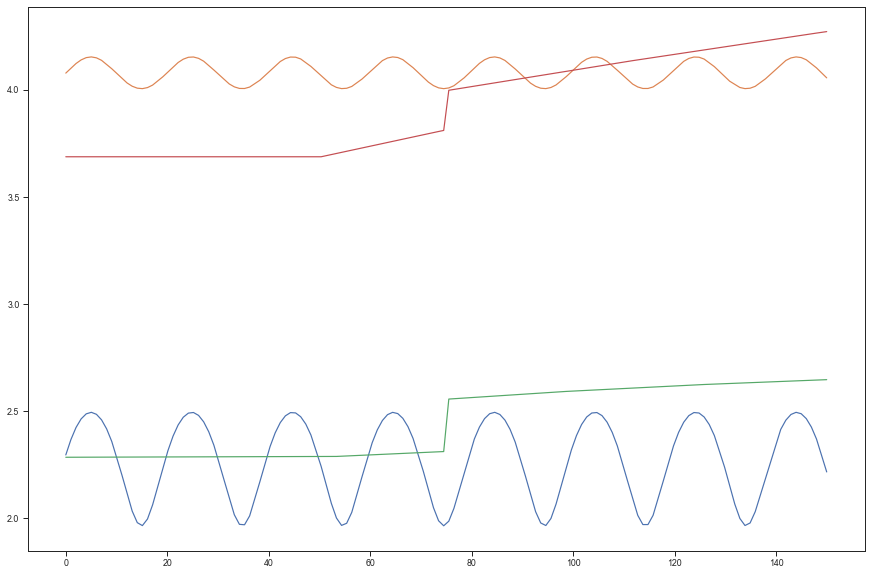

In [180]:
t_seg = np.linspace(0, true_w.shape[0], n_runs)

fig,axs = plt.subplots(figsize=(15,10))
for i in range(true_w.shape[1]):
    axs.plot(t_seg, true_w[:,i])

In [181]:
responses_noised=add_noise_response(responses,noise_fac)
lambds,phis=create_input_COVssi(responses,t,orders)

valid_range= { 'freq': [1e-4, np.inf],'damping': [1e-4,np.inf] }

indicator='freq'
s=1
stabcrit = {'freq':0.05, 'damping': 0.1, 'mac': 0.1}
prob_threshold = 0.5   #probability of pole to belong to 
# cluster, based on estimated "probability" density function

min_cluster_size=20 
min_samples=10
scaling={'mac':1.0, 'lambda_real':1.0, 'lambda_imag': 1.0}

In [182]:
phis_out,lambds_out=clustering(lambds,
phis,orders,s,stabcrit,valid_range,indicator,prob_threshold,
scaling,min_cluster_size,min_samples,true_w=true_w,plot=False)

../src\_clustering.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  omega_n_auto=np.array(lambds_n_auto)**0.5
../src\_clustering.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  omega_n_auto=np.array(lambds_n_auto)**0.5
../src\_clustering.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  omega_n_auto=np.array(lambds_n_aut

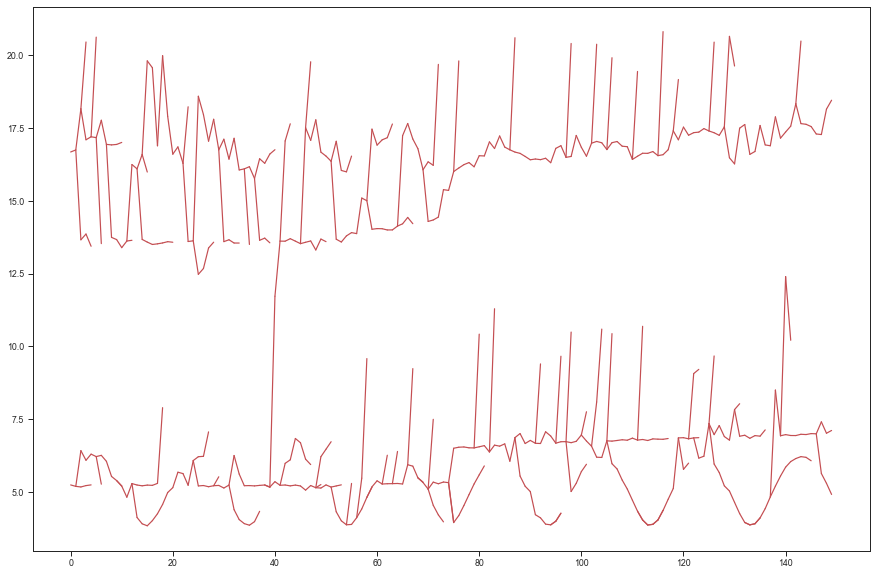

In [186]:
idf_track = tk.trackingAdvancedDistance(lambds_out, phis_out)
tk.tracking_plot(lambds_out, idf_track)

In [197]:
mode_traces = tk.perform_tracking(lambds_out, phis_out, n = 30, m = 5, d_track_threshold=0.3)

In [198]:
print(mode_traces)

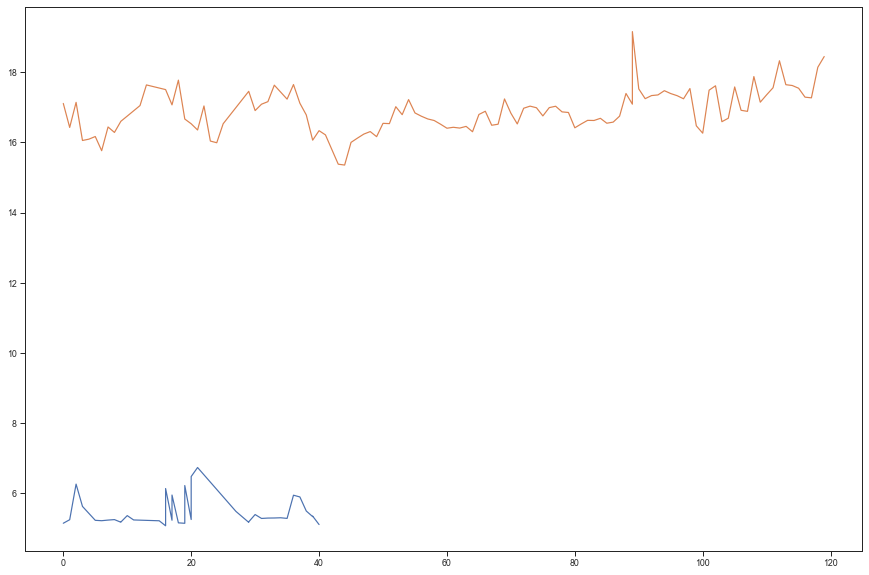

In [199]:
plt.figure(figsize=(15,10))
for i in range(len(mode_traces)):
    plt.plot(mode_traces[i].time_seg, mode_traces[i].frequencies)